#### CSE 252A Computer Vision I Fall 2021 - Assignment 2

In [1]:
import numpy as np
from time import time
from skimage import io
%matplotlib inline
import matplotlib.pyplot as plt
import math

In [3]:
def zero_pad(image, pad_top, pad_down, pad_left, pad_right):
    """ Zero-pad an image.

    Ex: a 1x1 image [[1]] with pad_top = 1, pad_down = 1, pad_left = 2, pad_right = 2 becomes:

        [[0, 0, 0, 0, 0],
         [0, 0, 1, 0, 0],
         [0, 0, 0, 0, 0]]         of shape (3, 5)

    Args:
        image: numpy array of shape (H, W)
        pad_left: width of the zero padding to the left of the first column
        pad_right: width of the zero padding to the right of the last column
        pad_top: height of the zero padding above the first row
        pad_down: height of the zero padding below the last row

    Returns:
        out: numpy array of shape (H + pad_top + pad_down, W + pad_left + pad_right)
    """
    
    left=np.zeros((image.shape[0],pad_left))
    right=np.zeros((image.shape[0], pad_right))
   
    out=np.concatenate((left,image,right), axis=1)

    up=np.zeros((pad_top, out.shape[1]))
    down=np.zeros((pad_down, out.shape[1]))
    out=np.concatenate((up,out,down), axis=0)

    return out

### Implementing Convolution

In [4]:
def conv(image, kernel):
    """ An efficient implementation of a convolution filter.

    This function uses element-wise multiplication and np.sum()
    to efficiently compute a weighted sum of the neighborhood at each
    pixel.

    Args:
        image: numpy array of shape (Hi, Wi)
        kernel: numpy array of shape (Hk, Wk)

    Returns:
        out: numpy array of shape (Hi, Wi)
    """
    
    
    """ ==========
    YOUR CODE HERE
    ========== """
    
    
    Hi, Wi = image.shape
    Hk, Wk = kernel.shape
    padded_img = zero_pad(image, Hk//2, Hk-Hk//2-1, Wk//2, Wk-Wk//2-1)
    out = np.zeros((Hi, Wi))
    
    flip_kernel = np.flip(np.flip(kernel, axis=0), axis=1) 
        
    for i in range(0,padded_img.shape[0]-Hk+1):
        for j in range(0, padded_img.shape[1]-Wk+1):
            
            temp = np.multiply(padded_img[i:i+Hk,j:j+Wk], flip_kernel)
            out[i][j]=np.sum(temp)
            
    return out

## Corner detection

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import imageio
from scipy.signal import convolve

def rgb2gray(rgb):
    """ Convert rgb image to grayscale.
    """
    return np.dot(rgb[...,:3], [0.299, 0.587, 0.114])

In [6]:
def gradientGxGy(image):
    """ ==========
    YOUR CODE HERE
    ========== """
    
    dx=np.array([[-1,0,1],
                 [-2,0,2],
                 [-1,0,1]])
    dy=np.array([[1,2,1],
                 [0,0,0],
                 [-1,-2,-1]])
    
    Gx = conv(image,dx)
    Gy = conv(image,dy)
    
#     g_mag = (Gx**2+Gy**2)**0.5
#     g_theta = np.arctan2(Gy, Gx)
    
    
    return Gx, Gy

def smooth(image, size, smoothSTD):
    """ ==========
    YOUR CODE HERE
    ========== """
    return conv(image, gaussian2d(size,smoothSTD))

def getSpatialGradientMatrix(gx, gy):
    m = np.zeros((2,2))
    m[0,0]=np.sum(gx**2)
    m[1,1]=np.sum(gy**2)
    t = np.sum(gx*gy)
    m[0,1], m[1,0] = t, t
    
    return m

In [7]:
def corner_detect(image, nCorners, smoothSTD, windowSize):
    """Detect corners on a given image.

    Args:
        image: Given a grayscale image on which to detect corners.
        nCorners: Total number of corners to be extracted.
        smoothSTD: Standard deviation of the Gaussian smoothing kernel.
        windowSize: Window size for corner detector and non-maximum suppression.

    Returns:
        Detected corners (in image coordinate) in a numpy array (n*2).

    """
    
    """ ==========
    YOUR CODE HERE
    ========== """
    
    # Smoothen the image
    smooth_ = gaussian_filter(image, sigma=smoothSTD)
    #     smooth = conv(image, gaussian)
    #     smooth_ = smooth(image, size=windowSize, smoothSTD=smoothSTD)
    
    # pad the image
    padded_smooth = zero_pad(smooth_, 
                      windowSize//2, 
                      windowSize-windowSize//2-1, 
                      windowSize//2, 
                      windowSize-windowSize//2-1)


    # Get Gradients at every pixel
    Gx, Gy = gradientGxGy(padded_smooth)

    # compute measurement image R
    # value at pixel = minimum eigenvalue for its spatial gradient matrix M    
    # Here R is going to be padded with zeros on the edge
    R = np.zeros_like(smooth_)

    for i in range(0, padded_smooth.shape[0]-windowSize+1):
        for j in range(0, padded_smooth.shape[1]-windowSize+1):

            M = getSpatialGradientMatrix(Gx[i:i+windowSize, j:j+windowSize], Gy[i:i+windowSize, j:j+windowSize])
            traceM = M[0,0]+M[1,1]
            detM = M[0,0]*M[1,1]-M[0,1]*M[0,1]

            R[i,j]=(traceM-(traceM**2-4*detM)**0.5)/2.0           

    # applying non maximum supression

    # pad R again to deal with edges
    padded_R = zero_pad(R, 
                      windowSize//2, 
                      windowSize-windowSize//2-1, 
                      windowSize//2, 
                      windowSize-windowSize//2-1)

    RMax = np.zeros_like(smooth_)
    for i in range(windowSize//2, padded_R.shape[0]-windowSize-windowSize//2+1):
        for j in range(windowSize//2, padded_R.shape[1]-windowSize-windowSize//2+1):
            window=padded_R[i:i+windowSize, j:j+windowSize]

            if padded_R[i+windowSize//2, j+windowSize//2] >= window.max():
                RMax[i, j] = padded_R[i+windowSize//2, j+windowSize//2]

    # get top n corners

    Y, X = np.unravel_index(np.argsort(RMax, axis=None,)[-nCorners:], RMax.shape)

    corners = []
    
    for x,y in zip(X,Y):
        corners.append((x,y))

    return np.asarray(corners)

In [8]:
def show_corners_result(imgs, corners):
    fig = plt.figure(figsize=(8, 8))
    ax1 = fig.add_subplot(221)
    ax1.imshow(imgs[0], cmap='gray')
    ax1.scatter(corners[0][:, 0], corners[0][:, 1], s=35, edgecolors='r', facecolors='none')

    ax2 = fig.add_subplot(222)
    ax2.imshow(imgs[1], cmap='gray')
    ax2.scatter(corners[1][:, 0], corners[1][:, 1], s=35, edgecolors='r', facecolors='none')
    plt.show()

smooth stdev: 2
window size: 13


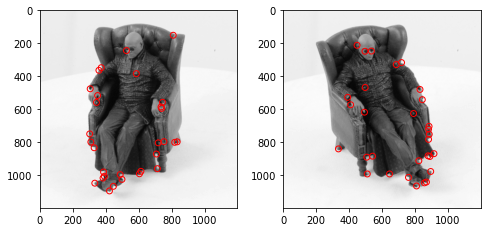

In [9]:
for smoothSTD in (2,):
    windowSize = int(smoothSTD * 6)
    if windowSize % 2 == 0:
        windowSize += 1
        
    print('smooth stdev: %r' % smoothSTD)
    print('window size: %r' % windowSize)

    nCorners = 30

    # read images and detect corners on images
    
    imgs_din = []
    crns_din = []
    imgs_mat = []
    crns_mat = []
    imgs_war = []
    crns_war = []
    
    for i in range(2):
        img_mat = imageio.imread('matrix/matrix' + str(i) + '.png')
        imgs_mat.append(rgb2gray(img_mat))
        # downsize your image in case corner_detect runs slow in test
        # imgs_mat.append(rgb2gray(img_mat)[::2, ::2])
        crns_mat.append(corner_detect(imgs_mat[i], nCorners, smoothSTD, windowSize))

    show_corners_result(imgs_mat, crns_mat)